In [1]:
import polars as pl
import polars.selectors as cs

## Overview

Next we look at applying the accumulation pattern to an arbitrary number of rows using the `reduce` and `fold` methods of a column expression, where

1. `reduce` uses the first column as the initial value, and
2. `fold` allows the user to specify an initial value.

## The data - Auto Sales for April and May

In [2]:
%%bash

ls -alG data | grep auto

-rw-------@  1 bn8210wy  staff      120 Feb 18  2021 auto_sales_apr.csv
-rw-------@  1 bn8210wy  staff      120 Feb 18  2021 auto_sales_may.csv


In [3]:
(auto_sale_apr_may :=
 pl.read_csv('./data/auto_sales_*.csv') # Using the `polars` built-in glob
 .rename({'':'ID'})
)

ID,Salesperson,Compact,Sedan,SUV,Truck
i64,str,i64,i64,i64,i64
0,"""Ann""",22,18,15,12
1,"""Bob""",19,12,17,20
2,"""Yolanda""",19,8,32,15
3,"""Xerxes""",12,23,18,9
0,"""Ann""",22,18,15,12
1,"""Bob""",20,14,6,24
2,"""Yolanda""",19,10,28,17
3,"""Xerxes""",11,27,17,9


## Accumulating columns

We want to scale up column formulas that compute statistics, like the

1. total,
2. max,
3. count of non-null, etc.

### Example - Compute the total auto sales per salesperson

1. Group and aggregate across rows,
2. Compute total across the sub-type columns.

#### Solution 1 - The WET solution

In [7]:
( auto_sale_apr_may
  .drop('ID')
  .group_by('Salesperson')
  .agg(pl.col('Compact').sum(),	
       pl.col('Sedan').sum(),	
       pl.col('SUV').sum(),	
       pl.col('Truck').sum(),
      )
  .with_columns(total = pl.col('Compact') +	pl.col('Sedan') + pl.col('SUV') +	pl.col('Truck'))
)

Salesperson,Compact,Sedan,SUV,Truck,total
str,i64,i64,i64,i64,i64
"""Ann""",44,36,30,24,134
"""Yolanda""",38,18,60,32,148
"""Bob""",39,26,23,44,132
"""Xerxes""",23,50,35,18,126


#### Cleaning up the aggregation with column selectors

In [10]:
( auto_sale_apr_may
  .drop('ID')
  .group_by('Salesperson')
  .agg(cs.integer().sum())
  .with_columns(total = pl.col('Compact') +	pl.col('Sedan') +	pl.col('SUV') +	pl.col('Truck'))
)

Salesperson,Compact,Sedan,SUV,Truck,total
str,i64,i64,i64,i64,i64
"""Ann""",44,36,30,24,134
"""Bob""",39,26,23,44,132
"""Yolanda""",38,18,60,32,148
"""Xerxes""",23,50,35,18,126


#### So, what about that mutate?  How do we clean that up?

**Answer.** Reduce!

### Recognizing the accumulator pattern

<div>
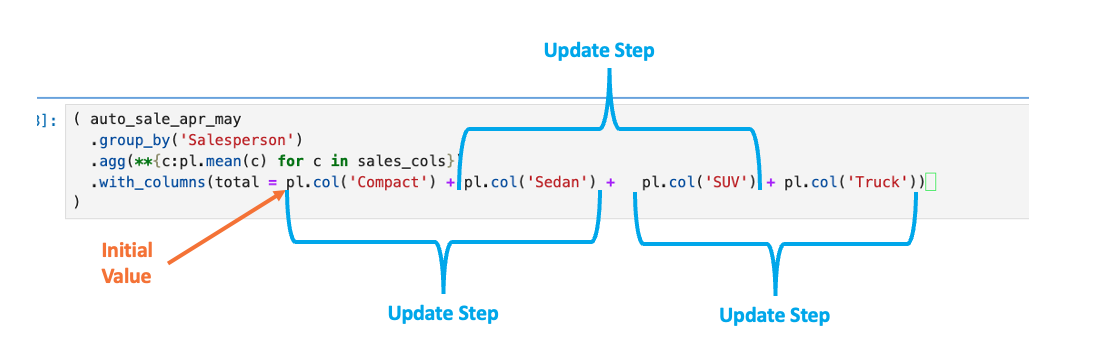
</div>



#### Abstracting the pattern with `reduce`

`reduce` takes
1. The update function, and
2. An expression that represents a collection of columns.

In [13]:
from operator import add

In [15]:
( auto_sale_apr_may
  .group_by('Salesperson')
  .agg((cs.integer() - cs.by_name('ID')).sum())
  .with_columns(total = pl.reduce(add, cs.integer()))
)

Salesperson,Compact,Sedan,SUV,Truck,total
str,i64,i64,i64,i64,i64
"""Yolanda""",38,18,60,32,148
"""Xerxes""",23,50,35,18,126
"""Ann""",44,36,30,24,134
"""Bob""",39,26,23,44,132


### Example 2 - Compute the minimum sales for each salesperson (across months and types).

#### WET solution

In [27]:
( auto_sale_apr_may
  .drop('ID')
  .group_by('Salesperson')
  .agg(cs.integer().min())
  .with_columns(total = pl.when(pl.col('Compact') <= pl.col('Sedan')))
)

ComputeError: the name 'total' passed to `LazyFrame.with_columns` is duplicate

It's possible that multiple expressions are returning the same default column name. If this is the case, try renaming the columns with `.alias("new_name")` to avoid duplicate column names.

## <font color="red">Exercise 3.8.1 - Compute other sales statistic</font>

Now suppose that we want to compute the overall *maximum* and *minumum* sales for each employee over both months and all sub-types.  Write a single dot-chain to accomplish this task twice 
1. First using the brute-force/WET solution, and then
2. Using `reduce` to perform the computation across the sub-type columns.

In [12]:
# Your WET code here

In [9]:
# Your reduce code here

## Pattern 2 - Providing an initial value

Suppose for some reason, we want pad the total sales numbers by 5.  In this case, we need to set the initial value explicitly.

In [10]:
( auto_sale_apr_may
  .group_by('Salesperson')
  .agg((cs.integer() - cs.by_name('ID')).sum())
  .with_columns(total_plus_five = pl.lit(5) + pl.col('Compact') +	pl.col('Sedan') +	pl.col('SUV') +	pl.col('Truck'))
)


Salesperson,Compact,Sedan,SUV,Truck,total_plus_five
str,i64,i64,i64,i64,i64
"""Xerxes""",23,50,35,18,131
"""Ann""",44,36,30,24,139
"""Yolanda""",38,18,60,32,153
"""Bob""",39,26,23,44,137


### Using `fold` to provide an initial value

In [11]:
( auto_sale_apr_may
  .group_by('Salesperson')
  .agg((cs.integer() - cs.by_name('ID')).sum())
  .with_columns(total_plus_five = pl.fold(pl.lit(5), lambda acc, col: acc + col, cs.integer()))
)


Salesperson,Compact,Sedan,SUV,Truck,total_plus_five
str,i64,i64,i64,i64,i64
"""Bob""",39,26,23,44,137
"""Xerxes""",23,50,35,18,131
"""Ann""",44,36,30,24,139
"""Yolanda""",38,18,60,32,153


## Example - Computing the Bayes estimate

**Question.** What it the probability that a randomly selected auto sale for Ann is a Compact or Sedan?

**Approach.** Estimate this answer using the Bayes rule (see [the sunrise problem](https://en.wikipedia.org/wiki/Sunrise_problem) for a history), e.g.,

$$Probability \approx \frac{Successes + 1}{Trials + 2}$$

#### Column aggregations via `fold`

In [26]:
(auto_sale_apr_may
 .group_by('Salesperson')
 .agg(cs.integer().sum())
 .filter(pl.col('Salesperson') == 'Ann')
 .with_columns(est_prob  = (pl.fold(pl.lit(1), lambda acc, col: acc + col, cs.by_name('Compact', 'Sedan'))/
                            pl.fold(pl.lit(2), lambda acc, col: acc + col, cs.integer() - cs.by_name('ID'))
                           )
              )
#  .drop(cs.integer())
)

Salesperson,ID,Compact,Sedan,SUV,Truck,est_prob
str,i64,i64,i64,i64,i64,f64
"""Ann""",0,44,36,30,24,0.595588


#### Replacing the `lambda` with a `polars` helper

In [25]:
(auto_sale_apr_may
 .group_by('Salesperson')
 .agg(cs.integer().sum())
 .filter(pl.col('Salesperson') == 'Ann')
 .with_columns(est_prob  = (pl.fold(pl.lit(1), pl.sum_horizontal, cs.by_name('Compact', 'Sedan'))/
                            pl.fold(pl.lit(2), pl.sum_horizontal, cs.integer() - cs.by_name('ID'))
                           )
              )
#  .drop(cs.integer())
)

Salesperson,ID,Compact,Sedan,SUV,Truck,est_prob
str,i64,i64,i64,i64,i64,f64
"""Ann""",0,44,36,30,24,0.595588


#### Column aggregations using `sum_horizontal`

In [23]:
(auto_sale_apr_may
 .group_by('Salesperson')
 .agg(cs.integer().sum())
 .filter(pl.col('Salesperson') == 'Ann')
 .with_columns(est_prob  = ((pl.sum_horizontal(cs.by_name('Compact', 'Sedan'))  + pl.lit(1))/
                            (pl.sum_horizontal(cs.integer() - cs.by_name('ID')) + pl.lit(2))
                           )
              )
#  .drop(cs.integer())
)

Salesperson,ID,Compact,Sedan,SUV,Truck,est_prob
str,i64,i64,i64,i64,i64,f64
"""Ann""",0,44,36,30,24,0.595588


## <font color="red">Exercise 3.8.2</font> - Estimating another probability

For each salesperson, estimate the probability that a randomly selected sale is either a Truck or Utility vehicle, two ways:
1. Use `fold` to aggregate across the rows, then
2. Replace the `fold`s with calls to `sum_horizontal`.


In [76]:
# Your code using fold  here

In [27]:
# Your code using sum_horizontal  here